In [1]:
%cd '/scratch/sk7898/l3embedding/classifier/sonyc_ust'
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import os
import yaml
import seaborn as sns
import matplotlib.pyplot as plt
import pickle as pk
import numpy as np
import sklearn
import networkx as nx
import pandas as pd
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, multilabel_confusion_matrix
from classify import get_file_targets, load_embeddings, construct_mlp_mil, construct_mlp_framewise

/scratch/sk7898/l3embedding/classifier/sonyc_ust


Using TensorFlow backend.


In [2]:
def plot_heatmap(
        prototypes, 
        target_labels, 
        ax,
        plot_title='Prototypes Dist. without perturbation',
        dist_path="dist.csv", 
        save_dist=False, 
        metric='euclidean'
    ):
    plt.sca(ax)
    dist = sklearn.metrics.pairwise_distances(prototypes, Y=None, metric=metric)
    ax = sns.heatmap(dist, xticklabels=target_labels, yticklabels=target_labels, vmax=35, linewidth=0.5)
    ax.set_title(plot_title)
    
    if save_dist:
        np.savetxt(dist_path, dist, delimiter=",")

In [3]:
def get_f1_score(y_true, y_pred, target_labels):
    mu = 0.5
    cm = multilabel_confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = {}, {}, {}, {}
    f1 = {}

    for idx, cls in enumerate(target_labels):
        tn[cls], fp[cls], fn[cls], tp[cls] = cm[idx].ravel()
        precision = tp[cls] / np.maximum(tp[cls] + fp[cls], mu)
        recall = tp[cls] / np.maximum(tp[cls] + fn[cls], mu)
        f1[cls] = 2 / (1/precision + 1/recall)

    return f1

In [4]:
def get_ground_truth(one_cls_targets):
    strt_idx = 0
    y_true = np.zeros((len(one_cls_targets), one_cls_targets.shape[1]), np.float32)

    for cls in range(one_cls_targets.shape[1]): 
        cls_idx = one_cls_targets[:, cls] == 1
        cls_count = len(one_cls_targets[cls_idx])
        y_true[strt_idx:strt_idx+cls_count, :] = one_cls_targets[cls_idx]
        strt_idx = strt_idx+cls_count
        
    return y_true

In [5]:
def get_prototypes(
        model,
        embeddings,
        one_cls_targets, 
        one_cls_files,
        one_cls_splits,
        threshold_dict=None,
        col=None, 
        frame_df=None, 
        ref_frame=False,
        emb_size=512
    ):
    
    row_list = []
    y_pred_mean = []
    y_pred_list = []
    prototypes = np.zeros((one_cls_targets.shape[1], emb_size), dtype=np.float32)
    
    for cls in range(one_cls_targets.shape[1]):
        per_cls_idxs = one_cls_targets[:, cls] == 1 
        cls_files = one_cls_files[per_cls_idxs]
        
        cls_mean_emb = np.zeros((len(per_cls_idxs), emb_size), dtype=np.float32)
        for i, (emb, audio_file, split) in enumerate(zip(embeddings[per_cls_idxs], one_cls_files[per_cls_idxs], one_cls_splits[per_cls_idxs])):
            pred = model.predict(emb) #shape: (91, 8)
            if ref_frame and frame_df is not None:
                frame_idx = frame_df[frame_df['audio_filename'] == audio_file].iloc[0]['frame_idx']
            else:
                frame_idx = np.argmax(pred[:, cls])
            
            #y_pred = np.round(pred[frame_idx, cls], 3)
            mean_pred = pred.mean(axis=0)
            y_pred = np.round(mean_pred[cls], 3)
            y_pred_list.append(y_pred)
            y_pred_mean.append(mean_pred.tolist())
            row_list.append([coarse_target_labels[cls], threshold_dict[cls+1], audio_file, split, frame_idx, y_pred])
                
            cls_mean_emb[i, :] = emb[frame_idx]
        prototypes[cls, :] = np.mean(cls_mean_emb, axis=0)    
        
    if frame_df is None:
        frame_df = pd.DataFrame(row_list, columns = ['coarse_label', 'threshold', 'audio_filename', 'split', 'frame_idx', 'softmax_confidence']) 
    else:
        if col in frame_df.columns:
            frame_df.drop(columns=[col])
        frame_df[col] = pd.Series(y_pred_list) > frame_df['threshold']
            
    return prototypes, y_pred_mean, frame_df

In [6]:
THRESH_DICT = {
    1: 0.60,
    2: 0.60, #0.2
    3: 0.20,
    4: 0.42,
    5: 0.33,
    6: 0.15,
    7: 0.40,
    8: 0.12
}

In [7]:
version = 'v0.4'
SONYC_PATH = '/scratch/work/sonyc/sonyc/ust/annotations'
EMBS_DIR = '/scratch/sk7898/sonyc_output/embeddings'
DATA_FOLDER = os.path.join('/scratch/sk7898/l3embedding/notebooks/data', version)
taxonomy_path = os.path.join(SONYC_PATH, '{}/dcase-ust-taxonomy.yaml'.format(version))

if version == 'v2.2':
    annotation_path = os.path.join(SONYC_PATH, 'latest/annotations_w_test_anns.csv')
else:
    annotation_path = os.path.join(SONYC_PATH, '{}/annotations.csv'.format(version))

annotation_data = pd.read_csv(annotation_path).sort_values('audio_filename')
annotation_data = annotation_data[annotation_data['annotator_id'] == 0]

with open(taxonomy_path, 'r') as f:
    taxonomy = yaml.load(f, Loader=yaml.Loader)
        
coarse_target_labels = ["_".join([str(k), v]) for k, v in taxonomy['coarse'].items()]
target_labels = [cls[2:] for cls in coarse_target_labels]
coarse_target_list = get_file_targets(annotation_data, coarse_target_labels)

In [9]:
one_cls_idxs = np.count_nonzero(coarse_target_list==1, axis=1) == 1
one_cls_targets = coarse_target_list[one_cls_idxs]
one_cls_files = np.array(annotation_data['audio_filename'])[one_cls_idxs]
one_cls_splits = np.array(annotation_data['split'])[one_cls_idxs]

per_cls_counts = np.count_nonzero(one_cls_targets==1, axis=0)
for cls, cls_name in enumerate(target_labels):
    total_cls_counts = per_cls_counts[cls]
    cls_idx = one_cls_targets[:, cls] == 1
    val_idxs = np.where(cls_idx & (one_cls_splits == 'validate'))
    test_idxs = np.where(cls_idx & (one_cls_splits == 'test'))
    print('{} \n\tTotal: {} Validate: {} Test: {}'.format(cls_name, total_cls_counts, len(one_cls_files[val_idxs]), len(one_cls_files[test_idxs])))

engine 
	Total: 159 Validate: 98 Test: 61
machinery-impact 
	Total: 17 Validate: 6 Test: 11
non-machinery-impact 
	Total: 9 Validate: 6 Test: 3
powered-saw 
	Total: 20 Validate: 13 Test: 7
alert-signal 
	Total: 50 Validate: 35 Test: 15
music 
	Total: 10 Validate: 6 Test: 4
human-voice 
	Total: 139 Validate: 100 Test: 39
dog 
	Total: 7 Validate: 1 Test: 6


In [10]:
cls_type = 'mlp'
emb_dir = os.path.join(EMBS_DIR, version, 'features/sonyc_ust/l3/melSpec_20200304183233_48000_256_242_2048')
cls_path = os.path.join(EMBS_DIR, version, 'classifier/sonyc_ust/{}/melSpec_20200304183233_48000_256_242_2048/0_0/results'.format(cls_type))

scaler_path = os.path.join(cls_path, 'stdizer.pkl')
scaler = pk.load(open(scaler_path,'rb'), encoding='utf-8')

/scratch/sk7898/miniconda3/envs/l3embedding-tf-2-gpu/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator StandardScaler from version 0.24.0 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [11]:
emb_size = 512

model_weight_file = os.path.join(cls_path, 'model_best.h5')
model = construct_mlp_framewise(emb_size, num_classes=8, sensor_factor=False, proximity_factor=False)
model.load_weights(model_weight_file)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 512)               0         
_________________________________________________________________
output (Dense)               (None, 8)                 4104      
Total params: 4,104
Trainable params: 4,104
Non-trainable params: 0
_________________________________________________________________
None


In [14]:
output_path = os.path.join(DATA_FOLDER, 'frames_for_viz.csv')

embeddings = load_embeddings(one_cls_files, emb_dir)
embeddings = np.array([scaler.transform(emb) for emb in embeddings])
_, num_frames, emb_size = embeddings.shape
    
ref_prototypes, ref_mean, frame_df = get_prototypes(
                           model,
                           embeddings, 
                           one_cls_targets, 
                           one_cls_files,
                           one_cls_splits,
                           threshold_dict=THRESH_DICT
            )
    
frame_df.to_csv(output_path, index=False)
frame_df = pd.read_csv(output_path)

In [15]:
thresh_arr = np.array(list(THRESH_DICT.values()))

y_true = get_ground_truth(one_cls_targets)
ref_mean = np.array(ref_mean)
y_pred = np.where(ref_mean > thresh_arr, 1, 0)

In [16]:
ref_f1 = get_f1_score(y_true, y_pred, target_labels)

In [17]:
ref_f1

{'engine': 0.8706624605678234,
 'machinery-impact': 0.6842105263157894,
 'non-machinery-impact': 0.14634146341463417,
 'powered-saw': 0.723404255319149,
 'alert-signal': 0.7394957983193275,
 'music': 0.3902439024390244,
 'human-voice': 0.8817891373801917,
 'dog': 0.42857142857142855}

In [18]:
perturbed_dir = '/scratch/work/sonyc/sonyc/ust/embeddings/openl3/perturbed'
p_dim = {
            'gain': [3, 6, 10],
            'reverb': ['0-10', '100-10', '50-10'],
            'highpass': [100, 400, 4000, 8000],
            'lowpass': [2000, 4000, 8000, 12000]
        }
prototypes = {}
pred_mean = {}

col_list = []
df = frame_df
for k, v in p_dim.items():
    for p in v:
        embeddings = None
        col_name = '{}_{}'.format(k, p)
        col_list.append(col_name)
        emb_dir = os.path.join(perturbed_dir, k, str(p))
        embeddings = load_embeddings(one_cls_files, emb_dir)
        embeddings = np.array([scaler.transform(emb) for emb in embeddings])
    
        prototypes[col_name], pred_mean[col_name], df = get_prototypes(
                                                            model,
                                                            embeddings, 
                                                            one_cls_targets, 
                                                            one_cls_files, 
                                                            one_cls_splits,
                                                            threshold_dict=THRESH_DICT,
                                                            col=col_name, 
                                                            frame_df=df
                                                        )

In [19]:
pert_f1 = {}

for k, v in pred_mean.items():
    ref_mean = np.array(v)
    y_pred = np.where(ref_mean > thresh_arr, 1, 0)
    pert_f1[k] = get_f1_score(y_true, y_pred, target_labels)

/scratch/sk7898/miniconda3/envs/l3embedding-tf-2-gpu/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()


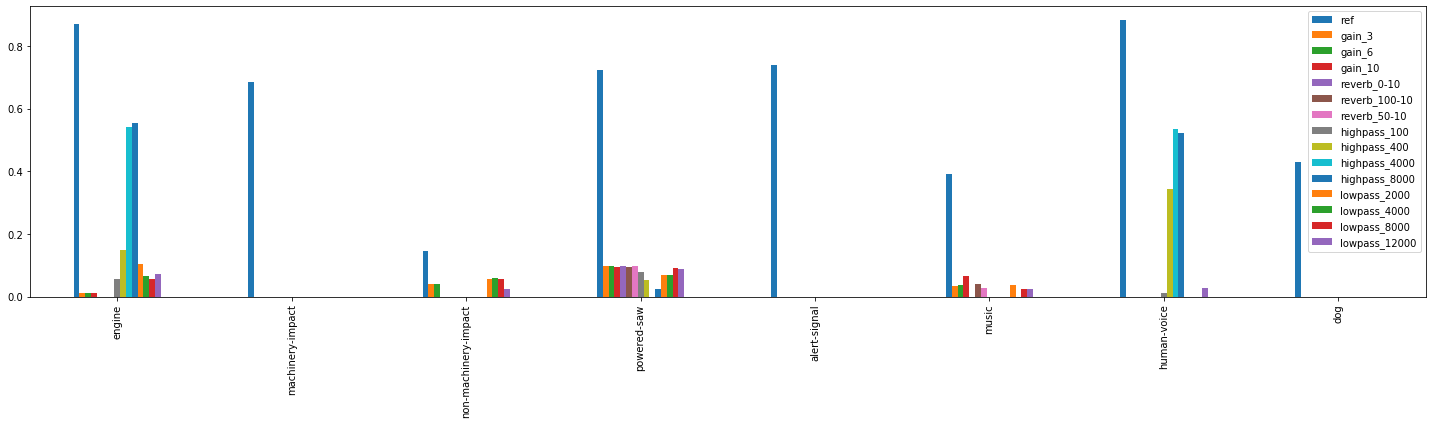

In [21]:
plt.rcParams["figure.figsize"] = (20, 6)
pert_f1['ref'] = ref_f1
df_res = pd.DataFrame.from_dict(pert_f1)

cols = ['ref'] + [col for col in df_res.columns if col != 'ref']
df_res = df_res[cols] 
df_res.plot(kind='bar')
plt.tight_layout()

In [22]:
cols = ['ref_tp'] + col_list

df['ref_tp'] = df['softmax_confidence'] > df['threshold']
df11 = df.groupby('coarse_label')[cols].apply(lambda x: (x == True).sum()).reset_index()
df11.set_index('coarse_label', inplace=True)

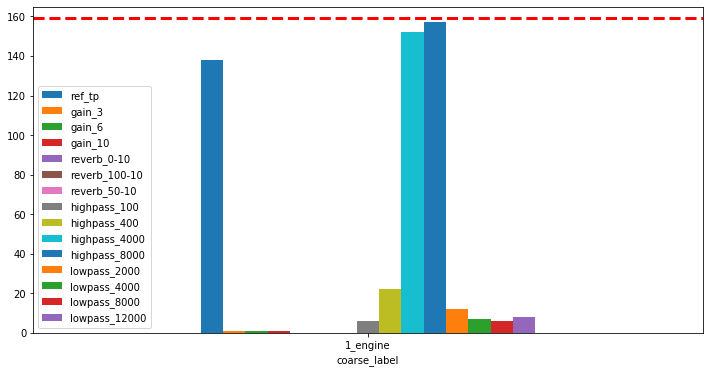

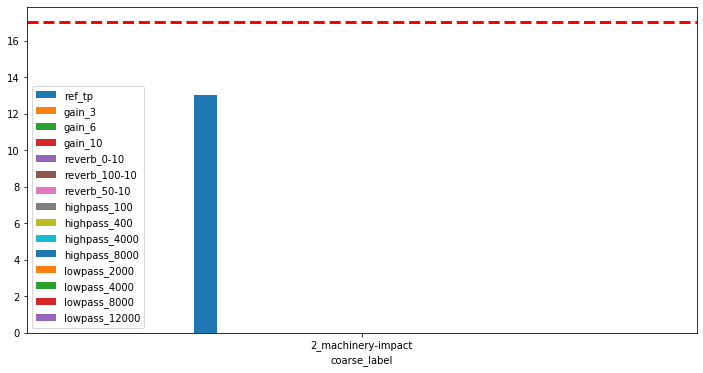

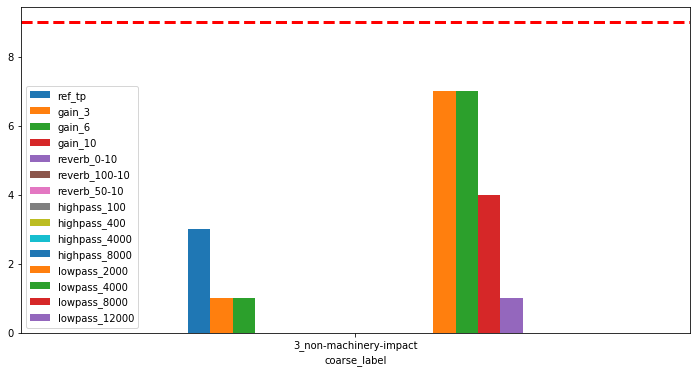

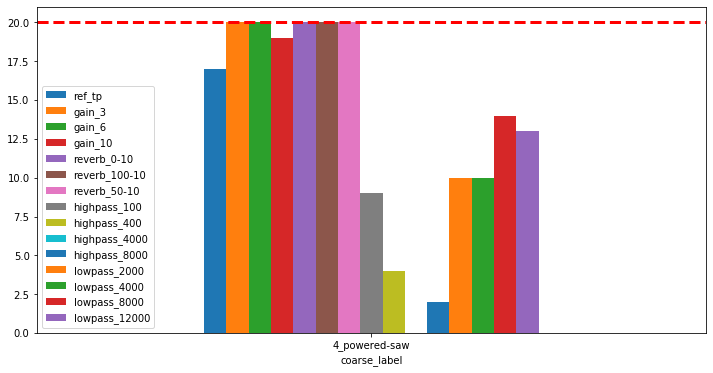

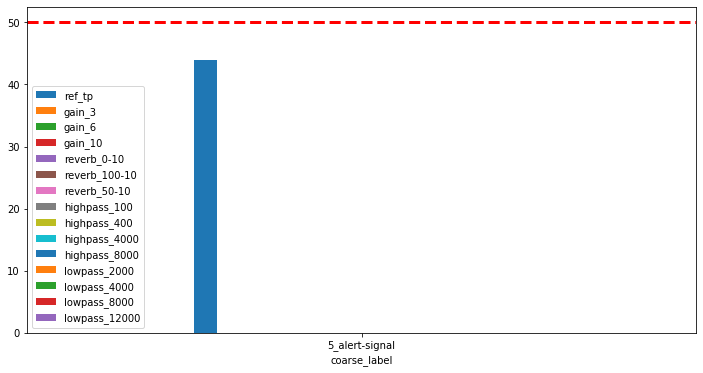

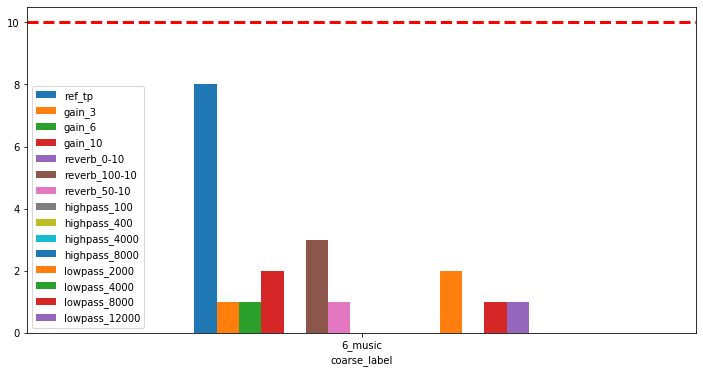

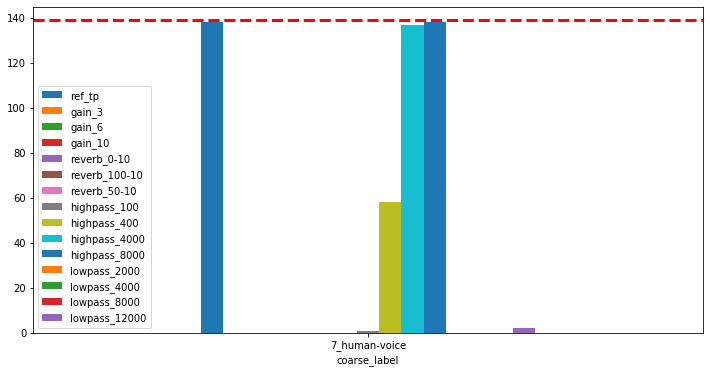

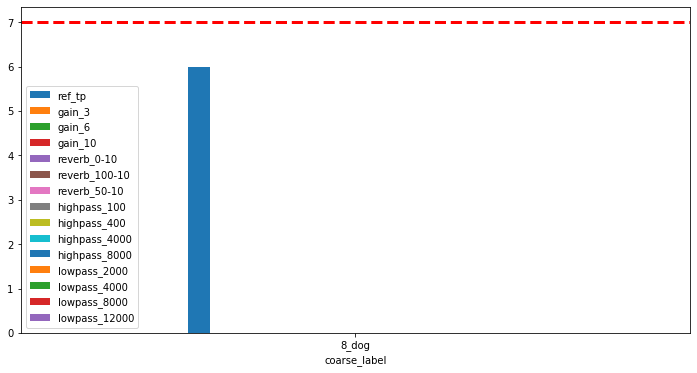

In [27]:
plt.rcParams["figure.figsize"] = (12, 6)

for cls in df11.index.tolist():
    cls_idx = int(cls[0]) - 1
    subset = df11[df11.index == cls]
    plot_subset = subset[cols]
    plot_subset.plot(kind='bar')
    plt.xticks(rotation = 0)
    plt.axhline(y=per_cls_counts[cls_idx], linewidth=3, linestyle='--', color='r')

In [24]:
df.head()
df.to_csv(output_path, index=False)

In [ ]:
import matplotlib.pyplot as plt
n = len(prototypes.keys())
fig, ax = plt.subplots(n, 1, figsize=(20, n*6)) #sharex=True

for i, (k, v) in enumerate(prototypes.items()):
    dist_dir = os.path.join(DATA_FOLDER, 'perturbed_dist')
    if not os.path.exists(dist_dir):
        os.makedirs(dist_dir)
    
    dist = sklearn.metrics.pairwise_distances(v, Y=ref_prototypes, metric='euclidean')
    dist_path = os.path.join(dist_dir, '{}.csv'.format(k))
    plot_heatmap(v, target_labels, ax=ax[i], plot_title=k, dist_path=dist_path, save_dist=True, metric='euclidean')

In [ ]:
from scipy.spatial import distance
for p1, p2 in zip(prototypes['lowpass_12000'], ref_prototypes):
    dist = distance.euclidean(p1, p2)
    print(dist)

In [ ]:
# plt.rcParams["figure.figsize"] = (20, 6)
# G = nx.Graph()
# for i in range(dist.shape[0]):
#     for j in range(dist.shape[0]):
#         if i != j:
#             G.add_edge(i, j, weight=dist[i][j])

# G = nx.relabel_nodes(G, dict(zip(range(len(G.nodes())), target_labels)))
# labels = nx.get_edge_attributes(G,'weight')
# for k in labels.keys():
#     labels[k] = round(labels[k], 1)
# nx.draw_networkx_edge_labels(G, pos=nx.spring_layout(G), edge_labels=labels)

# nx.draw(G, with_labels=True, pos=nx.spring_layout(G), font_weight='bold', node_color='salmon')